# Making zoom-in figures with matplotlib

This will walk through the process of making zoom-in figures with matplotlib.

## Step 1: imports.

In [1]:
# make the plots in the notebook
%matplotlib inline

In [2]:
# create a shorthand for the pyplot stuff (many people use plt)
import pylab as pl

In [3]:
# we'll use a FITS file
from astropy.io import fits

In [4]:
# we need the WCS from astropy (world coordinate system)
from astropy.wcs import WCS
# and we want visualization tools
from astropy import visualization

In [5]:
# we're going to use the warnings module so we can ignore warnings
import warnings

In [6]:
# load the FITS file
# fh is short for "filehandle"
fh = fits.open('/orange/adamginsburg/sgrb2/2013.1.00269.S/continuum/SgrB2_selfcal_full_TCTE7m_try2_selfcal6_ampphase_taper1.5as_r2_mask5mJy.image.tt0.pbcor.fits')

In [7]:
# load the WCS object, then print it to verify that it is two-dimensional
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ww = WCS(fh[0].header)
ww

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 266.830175  -28.39256111111  
CRPIX : 901.0  901.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -8.333333333333e-05  8.333333333333e-05  
NAXIS : 1800  1800

With the data loaded, we now make a simple plot:

In [8]:
# verify that the data are two-dimensional
fh[0].data.shape

(1800, 1800)

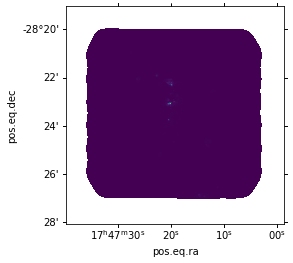

In [9]:
# very simple image with labeled axes
ax = pl.subplot(projection=ww)
ax.imshow(fh[0].data)

You probably want to change the colorscheme and axis labels, and you want to add a colorbar:

In [10]:
# the World Coordinate System stores internally the RA/Dec system
# (this can be FK5 or ICRS.  They differ only slightly, but it's enough to matter - 0.04")
ww.wcs.radesys

'FK5'

In [11]:
# the header contains the BUNIT
fh[0].header['BUNIT']

'Jy/beam'

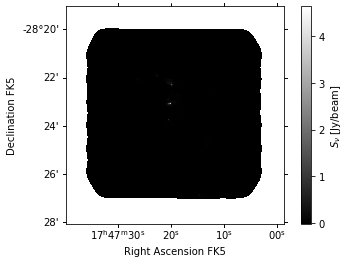

In [12]:
ax = pl.subplot(projection=ww)
im = ax.imshow(fh[0].data, cmap='gray')
cb = pl.colorbar(mappable=im)
cb.set_label(f"$S_\\nu$ [{fh[0].header['BUNIT']}]")
_ = ax.set_xlabel(f"Right Ascension {ww.wcs.radesys}")
_ = ax.set_ylabel(f"Declination {ww.wcs.radesys}")

You can't see anything in that figure, so change the colorscheme using astropy.visualization.simple_norm:

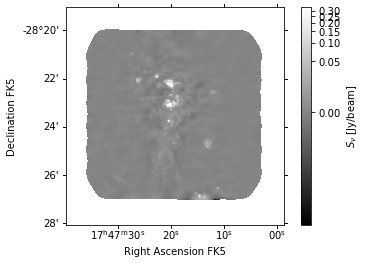

In [13]:
ax = pl.subplot(projection=ww)
im = ax.imshow(fh[0].data, cmap='gray', norm=visualization.simple_norm(fh[0].data, stretch='log', max_percent=99.95))
cb = pl.colorbar(mappable=im)
cb.set_label(f"$S_\\nu$ [{fh[0].header['BUNIT']}]")
_ = ax.set_xlabel(f"Right Ascension {ww.wcs.radesys}")
_ = ax.set_ylabel(f"Declination {ww.wcs.radesys}")

The colorbar is hideous, so we can manually set the ticks.

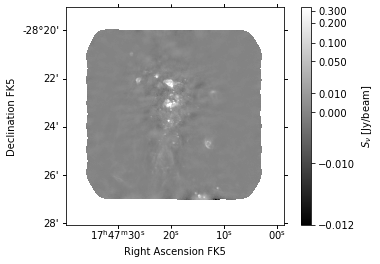

In [14]:
ax = pl.subplot(projection=ww)
im = ax.imshow(fh[0].data, cmap='gray', norm=visualization.simple_norm(fh[0].data, stretch='log', max_percent=99.95))
cb = pl.colorbar(mappable=im)
cb.set_label(f"$S_\\nu$ [{fh[0].header['BUNIT']}]")
cb.set_ticks([np.nanmin(fh[0].data), -0.01, 0.00, 0.01, 0.05, 0.10, 0.20, 0.30])
_ = ax.set_xlabel(f"Right Ascension {ww.wcs.radesys}")
_ = ax.set_ylabel(f"Declination {ww.wcs.radesys}")

We don't want to show the NAN parts of the image.  There are several options here:

 * Show the whole image, then "zoom in" the figure after the fact
 * Crop the image first
 
We'll do the first approach this time.

The image is 1800x1800, so I'll just guess that we can cut off 100 pixels on each side:

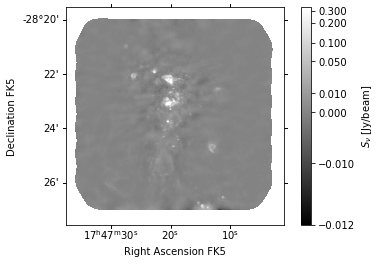

In [15]:
ax = pl.subplot(projection=ww)
im = ax.imshow(fh[0].data, cmap='gray', norm=visualization.simple_norm(fh[0].data, stretch='log', max_percent=99.95))
cb = pl.colorbar(mappable=im)
cb.set_label(f"$S_\\nu$ [{fh[0].header['BUNIT']}]")
cb.set_ticks([np.nanmin(fh[0].data), -0.01, 0.00, 0.01, 0.05, 0.10, 0.20, 0.30])
ax.axis([100,1700,100,1700])
_ = ax.set_xlabel(f"Right Ascension {ww.wcs.radesys}")
_ = ax.set_ylabel(f"Declination {ww.wcs.radesys}")

That's not quite perfect.  You can find the precise edges using some tricks: find out where there are non-NaN values along each axis.

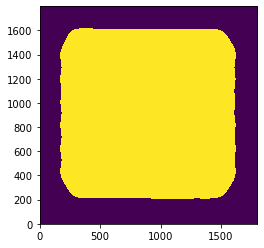

In [16]:
notnan = np.isfinite(fh[0].data)
pl.imshow(notnan, origin='lower')

We check if there are _any_ non-nan values along axis 0 (along the y-axis) first, then along the x-axis.

In [17]:
np.any(notnan, axis=0)

array([False, False, False, ..., False, False, False])

We use `np.argmax` to find the first `True` value in that array (there is one, it's just not shown

In [18]:
np.argmax(np.any(notnan, axis=0)), np.argmax(np.any(notnan, axis=1))

(167, 210)

That's the bottom-left corner of the image.

The top right is trickier...

In [19]:
notnan.shape[1] - np.argmax(np.any(notnan[::-1,::-1], axis=0)), notnan.shape[0] - np.argmax(np.any(notnan[::-1,::-1], axis=1))

(1617, 1618)

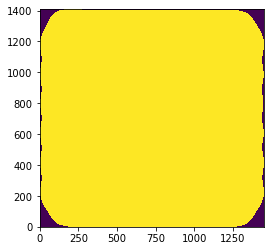

In [20]:
pl.imshow(notnan[210:1618, 167:1617], origin='lower')

We can now use that to crop out our image:

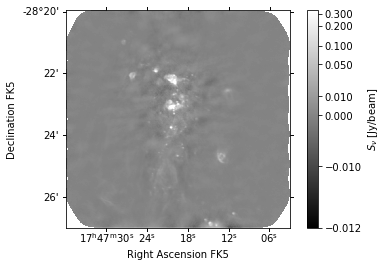

In [21]:
ax = pl.subplot(projection=ww)
im = ax.imshow(fh[0].data, cmap='gray', norm=visualization.simple_norm(fh[0].data, stretch='log', max_percent=99.95))
cb = pl.colorbar(mappable=im)
cb.set_label(f"$S_\\nu$ [{fh[0].header['BUNIT']}]")
cb.set_ticks([np.nanmin(fh[0].data), -0.01, 0.00, 0.01, 0.05, 0.10, 0.20, 0.30])
ax.axis([167,1617,210,1618])
_ = ax.set_xlabel(f"Right Ascension {ww.wcs.radesys}")
_ = ax.set_ylabel(f"Declination {ww.wcs.radesys}")

Let's do some small tweaks to the axis labels:

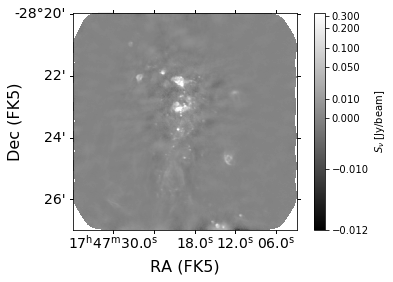

In [22]:
ax = pl.subplot(projection=ww)
im = ax.imshow(fh[0].data, cmap='gray', norm=visualization.simple_norm(fh[0].data, stretch='log', max_percent=99.95))
cb = pl.colorbar(mappable=im)
cb.set_label(f"$S_\\nu$ [{fh[0].header['BUNIT']}]")
cb.set_ticks([np.nanmin(fh[0].data), -0.01, 0.00, 0.01, 0.05, 0.10, 0.20, 0.30])
ax.axis([167,1617,210,1618])
radesys = ww.wcs.radesys
_ = ax.set_xlabel(f"Right Ascension {radesys}")
_ = ax.set_ylabel(f"Declination {radesys}")

tick_fontsize = 14
fontsize = 16
ra = ax.coords['ra']
ra.set_major_formatter('hh:mm:ss.s')
dec = ax.coords['dec']
ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
ra.ticklabels.set_fontsize(tick_fontsize)
ra.set_ticklabel(exclude_overlapping=True)
dec.ticklabels.set_fontsize(tick_fontsize)
dec.set_ticklabel(exclude_overlapping=True)

The above figure is decent, and even publishable.  I'm calling it good enough for current purposes.  Let's move on to zooming.

# Inset Zooms

Matplotlib gives several ways to build zoomed insets.

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes

We have to start with our previous figure.  Let's shorten it by putting it into a function (this is generally a good idea!)

In [24]:
def basefigure():
    ax = pl.subplot(projection=ww)
    im = ax.imshow(fh[0].data, cmap='gray', norm=visualization.simple_norm(fh[0].data, stretch='log', max_percent=99.95))
    cb = pl.colorbar(mappable=im)
    cb.set_label(f"$S_\\nu$ [{fh[0].header['BUNIT']}]")
    cb.set_ticks([np.nanmin(fh[0].data), -0.01, 0.00, 0.01, 0.05, 0.10, 0.20, 0.30])
    ax.axis([167,1617,210,1618])
    radesys = ww.wcs.radesys
    _ = ax.set_xlabel(f"Right Ascension {radesys}")
    _ = ax.set_ylabel(f"Declination {radesys}")

    tick_fontsize = 14
    fontsize = 16
    ra = ax.coords['ra']
    ra.set_major_formatter('hh:mm:ss.s')
    dec = ax.coords['dec']
    ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
    dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
    ra.ticklabels.set_fontsize(tick_fontsize)
    ra.set_ticklabel(exclude_overlapping=True)
    dec.ticklabels.set_fontsize(tick_fontsize)
    dec.set_ticklabel(exclude_overlapping=True)
    
    return ax

There are a ton of parameters to mess with on these zoom-ins:

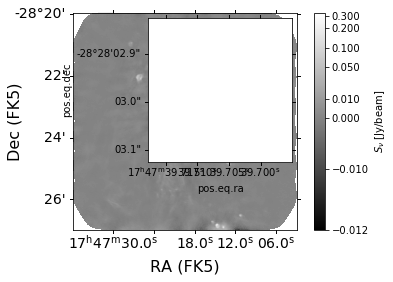

In [25]:
ax = basefigure()
axins = inset_axes(ax,
                   loc=1, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww))

The above plot created an axis, but didn't show anything.

If we just show the whole data set on top of the original, it looks pretty silly:

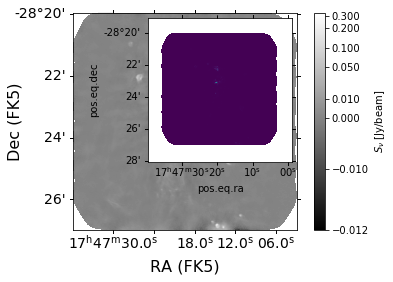

In [26]:
ax = basefigure()
axins = inset_axes(ax,
                   loc=1, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww))
axins.imshow(fh[0].data)

But if we show a cutout, we can zoom in, which is what we want:

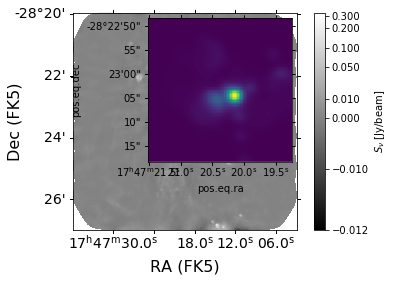

In [27]:
ax = basefigure()
axins = inset_axes(ax,
                   loc=1, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww))
# we need to specify the extent so matplotlib knows where our cutout came from
axins.imshow(fh[0].data[950:1050,800:900], extent=[800,900,950,1050])

We can move the "zoom" outside the box:

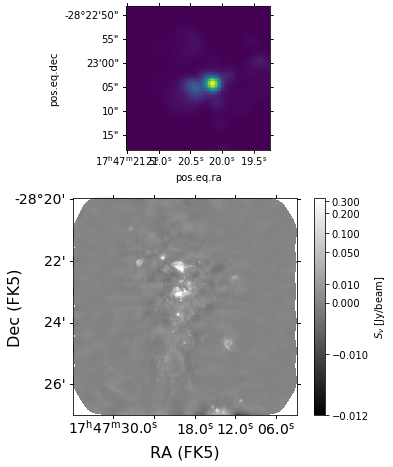

In [28]:
ax = basefigure()
axins = inset_axes(ax,
                   loc=1, width=2, height=2,
                   bbox_to_anchor=(0,0,300,450),
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww))
axins.imshow(fh[0].data[950:1050,800:900], extent=[800,900,950,1050])

We can show where we cut out from:

In [29]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x2ac35ba3fd68>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x2ac35ba35240>)

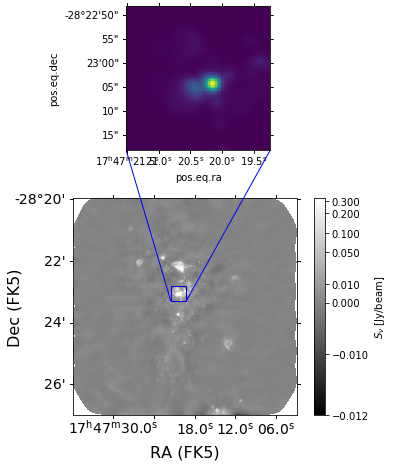

In [30]:
ax = basefigure()
axins = inset_axes(ax,
                   loc=1, width=2, height=2,
                   bbox_to_anchor=(0,0,300,450),
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww))
axins.imshow(fh[0].data[950:1050,800:900], extent=[800,900,950,1050])
mark_inset(parent_axes=ax, inset_axes=axins,
                   fc="none", ec="b", loc1=3, loc2=4)

We might want to do this differently, though.... what if we want to show the zooms within the image?

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x2ac36043b320>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x2ac36043b748>)

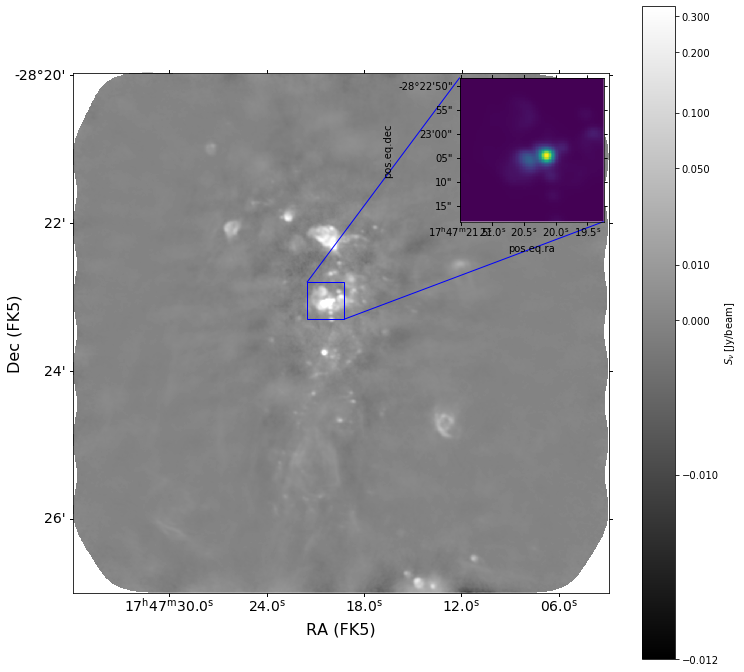

In [31]:
fig = pl.figure(figsize=(12,12))
ax = basefigure()
axins = inset_axes(ax,
                   loc=1, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww))
axins.imshow(fh[0].data[950:1050,800:900], extent=[800,900,950,1050])
mark_inset(parent_axes=ax, inset_axes=axins,
                   fc="none", ec="b", loc1=2, loc2=4)

We can show a second zoom:

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x2ac35bf4f4e0>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x2ac35bf4f828>)

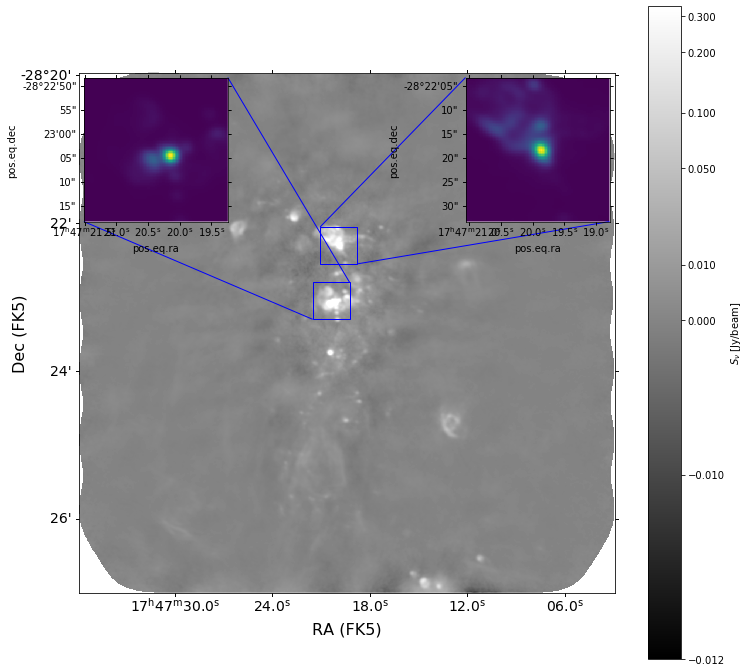

In [32]:
fig = pl.figure(figsize=(12,12))
ax = basefigure()
axins = inset_axes(ax,
                   loc=1, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww))
axins.imshow(fh[0].data[1100:1200,820:920], extent=[820,920,1100,1200])
mark_inset(parent_axes=ax, inset_axes=axins,
                   fc="none", ec="b", loc1=2, loc2=4)


axins2 = inset_axes(ax,
                   loc=2, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww))
axins2.imshow(fh[0].data[950:1050,800:900], extent=[800,900,950,1050])
mark_inset(parent_axes=ax, inset_axes=axins2,
                   fc="none", ec="b", loc1=1, loc2=3)

We probably don't want any of those ticks showing, though

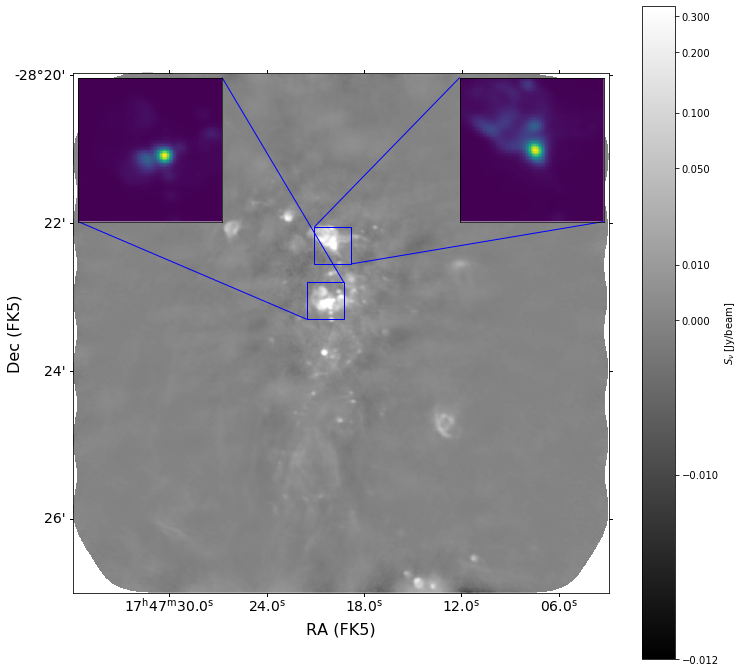

In [33]:
fig = pl.figure(figsize=(12,12))
ax = basefigure()
axins = inset_axes(ax,
                   loc=1, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww))
axins.imshow(fh[0].data[1100:1200,820:920], extent=[820,920,1100,1200])
mark_inset(parent_axes=ax, inset_axes=axins,
                   fc="none", ec="b", loc1=2, loc2=4)

ra = axins.coords['ra']
dec = axins.coords['dec']
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)
ra.set_axislabel('')
dec.set_axislabel('')
ra.ticklabels.set_visible(False)
dec.ticklabels.set_visible(False)



axins2 = inset_axes(ax,
                   loc=2, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww))
axins2.imshow(fh[0].data[950:1050,800:900], extent=[800,900,950,1050])
mark_inset(parent_axes=ax, inset_axes=axins2,
                   fc="none", ec="b", loc1=1, loc2=3)


ra = axins2.coords['ra']
dec = axins2.coords['dec']
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ra.set_ticks_visible(False)
dec.set_ticks_visible(False)
ra.set_axislabel('')
dec.set_axislabel('')
ra.ticklabels.set_visible(False)
dec.ticklabels.set_visible(False)

Seems tedious?  Well,  it's best to script it.  I'll borrow some of my ALMA-IMF scripts.

This material took some time to put together.  It is just combinations of the stuff I showed you above, but it wraps it all together.

In [34]:
from astropy import units as u
from astropy import coordinates
from astropy.stats import mad_std
from astropy.visualization import simple_norm
import astropy.visualization
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import radio_beam


def make_scalebar(ax, left_side, length, color='w', linestyle='-', label='',
                  fontsize=12, text_offset=0.1*u.arcsec):
    axlims = ax.axis()
    lines = ax.plot(u.Quantity([left_side.ra, left_side.ra-length]),
                    u.Quantity([left_side.dec]*2),
                    color=color, linestyle=linestyle, marker=None,
                    transform=ax.get_transform('fk5'),
                   )
    txt = ax.text((left_side.ra-length/2).to(u.deg).value,
                  (left_side.dec+text_offset).to(u.deg).value,
                  label,
                  verticalalignment='bottom',
                  horizontalalignment='center',
                  transform=ax.get_transform('fk5'),
                  color=color,
                  fontsize=fontsize,
                 )
    ax.axis(axlims)
    return lines,txt



def make_zoom(filename, zoom_parameters,
              overview_vis_pars={'max_percent':99.5, 'min_percent':0.5, 'stretch':'linear'},
              overview_cmap='gray_r',
              inset_cmap='inferno',
              main_zoombox=None,
              scalebar_loc=(0.1,0.1),
              scalebar_length=0.1*u.pc,
              beam_loc=(0.05, 0.05),
              nsigma_asinh=5,
              nsigma_max=10,
              nticks_inset=7,
              fontsize=20,
              tick_fontsize=16,
              distance=8.5*u.kpc
             ):

    fh = fits.open(filename)
    img = fh[0].data
    ww = WCS(fh[0].header)
    
    # cut out the minimal region that has data in it
    lbx,lby = np.argmax(np.any(notnan, axis=0)), np.argmax(np.any(notnan, axis=1))
    rtx,rty = notnan.shape[1] - np.argmax(np.any(notnan[::-1,::-1], axis=0)), notnan.shape[0] - np.argmax(np.any(notnan[::-1,::-1], axis=1))
    
    img = img[lby:rty, lbx:rtx]
    ww = ww[lby:rty, lbx:rtx]
    
    radesys = ww.wcs.radesys.upper()

    fig = pl.figure(1, figsize=(10,10))
    fig.clf()
    ax = fig.add_subplot(projection=ww.celestial)

    norm = simple_norm(img, **overview_vis_pars)

    img[img==0] = np.nan
    mad = mad_std(img, ignore_nan=True)

    if hasattr(norm.stretch, 'a') and nsigma_asinh is not None:
        norm.vmax = (np.nanmedian(img) + nsigma_max*mad)
        a_point = (np.nanmedian(img) + nsigma_asinh*mad) / norm.vmax
        norm.stretch.a = a_point
        print(f"numbers for norm: {np.nanmedian(img), nsigma_asinh, mad, nsigma_asinh*mad, norm.vmax, a_point}")

    im = ax.imshow(img, cmap=overview_cmap, norm=norm)

    ra = ax.coords['ra']
    ra.set_major_formatter('hh:mm:ss.s')
    dec = ax.coords['dec']
    ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
    dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
    ra.ticklabels.set_fontsize(tick_fontsize)
    ra.set_ticks(exclude_overlapping=True)
    dec.ticklabels.set_fontsize(tick_fontsize)
    dec.set_ticks(exclude_overlapping=True)


    for zp in zoom_parameters:

        xl,xr = zp['xl'], zp['xr']
        yl,yu = zp['yl'], zp['yu']
        slc = [slice(yl,yu), slice(xl,xr)]
        axins = inset_axes(ax, **zp['inset_pars'],
                           axes_class=astropy.visualization.wcsaxes.core.WCSAxes,
                           axes_kwargs=dict(wcs=ww.celestial))

        norm2 = simple_norm(img, **zp['vis_pars'])

        inset_cm = copy.copy(pl.cm.get_cmap(inset_cmap))
        inset_cm.set_bad(inset_cm(0))

        im_ins = axins.imshow(img[slc], extent=[xl,xr,yl,yu], cmap=inset_cm, norm=norm2)
        mark_inset(parent_axes=ax, inset_axes=axins,
                   fc="none", ec="b", **zp['mark_inset_pars'])
        ra = axins.coords['ra']
        dec = axins.coords['dec']
        axins.set_xticklabels([])
        axins.set_yticklabels([])
        axins.xaxis.set_visible(False)
        axins.yaxis.set_visible(False)
        ra.set_ticks_visible(False)
        dec.set_ticks_visible(False)
        ra.set_axislabel('')
        dec.set_axislabel('')
        ra.ticklabels.set_visible(False)
        dec.ticklabels.set_visible(False)

        caxins = inset_axes(axins,
                 width="5%", # width = 10% of parent_bbox width
                 height="100%", # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=axins.transAxes,
                 borderpad=0,
                 )

        cbins = pl.colorbar(mappable=im_ins, cax=caxins)
        cbins.ax.tick_params(labelsize=tick_fontsize)
        cbins.set_label(f"S$_\\nu$ [Jy beam$^{-1}$]", fontsize=fontsize)

        if 'tick_locs' in zp:
            cbins.set_ticks(zp['tick_locs'])
            if 'tick_labels' in zp:
                cbins.set_ticklabels(zp['tick_labels'])
        elif 'asinh' in str(norm2.stretch).lower():
            rounded_loc, rounded = determine_asinh_ticklocs(norm2.vmin, norm2.vmax, nticks=nticks_inset)
            cbins.set_ticks(rounded_loc)
            cbins.set_ticklabels(rounded)
        elif'log' in str(norm2.stretch).lower():
            if norm2.vmin > 0:
                rounded_loc, rounded = determine_asinh_ticklocs(norm2.vmin, norm2.vmax, nticks=nticks_inset, rms=mad, stretch='log')
                cbins.set_ticks(rounded_loc)
                cbins.set_ticklabels(rounded)
            else:
                ticks = cbins.get_ticks()
                newticks = [norm2.vmin] + list(ticks)
                newticks = [norm2.vmin, 0,] + list(np.geomspace(mad, norm2.vmax, 4))
                print(f"ticks={ticks}, newticks={newticks}, mad={mad}, vmin={norm2.vmin}")
                cbins.set_ticks(newticks)

    if main_zoombox:
        ax.axis(main_zoombox)

    divider = make_axes_locatable(ax)
    cax1 = fig.add_axes([ax.get_position().x1+0.01,
                         ax.get_position().y0,
                         0.02,
                         ax.get_position().height])
    cb1 = pl.colorbar(mappable=im, cax=cax1)
    cb1.ax.tick_params(labelsize=tick_fontsize)
    cb1.set_label(f"S$_\\nu$ [Jy beam$^{-1}$]", fontsize=fontsize)
    pl.setp(cb1.ax.yaxis.get_label(), backgroundcolor="white")

    left_side = coordinates.SkyCoord(*ww.celestial.wcs_pix2world(scalebar_loc[1]*img.shape[1],
                                                                        scalebar_loc[0]*img.shape[0], 0)*u.deg, frame='fk5')
    length = (scalebar_length / distance).to(u.arcsec, u.dimensionless_angles())
    make_scalebar(ax, left_side, length, color='k', linestyle='-', label=f'{scalebar_length:0.1f}',
                  text_offset=0.5*u.arcsec, fontsize=fontsize)

    beam = radio_beam.Beam.from_fits_header(fh[0].header)
    ell = beam.ellipse_to_plot(beam_loc[1]*img.shape[1], beam_loc[0]*img.shape[0], pixscale=ww.celestial.pixel_scale_matrix[1,1]*u.deg)
    ax.add_patch(ell)

In [35]:
np.argmax(np.any(notnan, axis=0)), np.argmax(np.any(notnan, axis=1))

(167, 210)

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

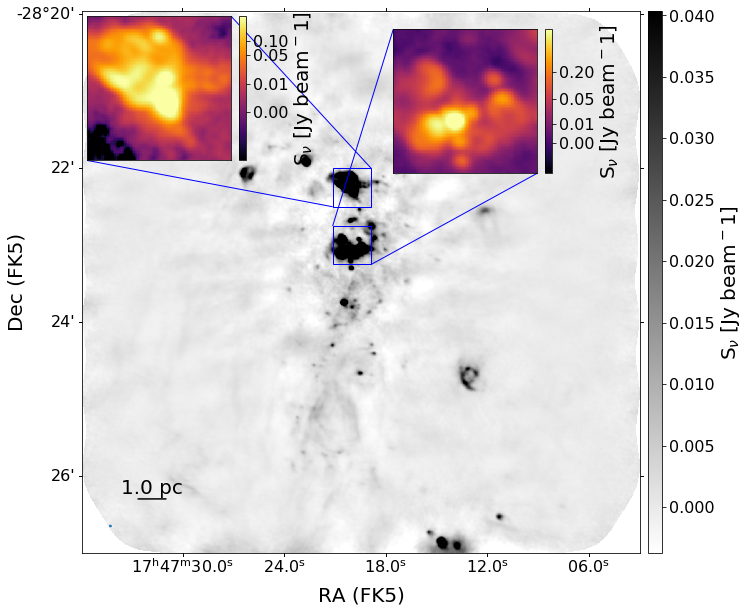

In [36]:
make_zoom(filename='/orange/adamginsburg/sgrb2/2013.1.00269.S/continuum/SgrB2_selfcal_full_TCTE7m_try2_selfcal6_ampphase_taper1.5as_r2_mask5mJy.image.tt0.pbcor.fits',
          zoom_parameters=[{'xl':650, 'xr':750, 'yl':750, 'yu':850, 
                            'inset_pars':{'loc': 1, 'width':2, 'height':2, 'bbox_to_anchor': (450,520,100,100)},
                            'mark_inset_pars':{'loc1':2, 'loc2':4,},
                            'tick_locs': [-0.01, 0, 0.01, 0.05, 0.2],
                            'vis_pars':{'max_percent':99.995, 'min_percent': 0.1, 'stretch':'log'}
                           },
                           {'xl':650, 'xr':750, 'yl':900, 'yu':1000, 
                            'inset_pars':{'loc': 2, 'width':2, 'height':2},
                            'mark_inset_pars':{'loc1':1, 'loc2':3,},
                            'tick_locs': [-0.01, 0, 0.01, 0.05, 0.1],
                            'vis_pars':{'max_percent':99.95, 'min_percent': 1, 'stretch':'log'}
                           },
                          ],
          scalebar_length=1*u.pc,
          distance=8.5*u.kpc
         )

# Zooming in to data from _other_ images

The really useful stuff comes from overlaying other data

In [37]:
fh2 = fits.open('/orange/adamginsburg/sgrb2/NB/NB.sgr_b2.N.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits')
im2 = fh2[0].data.squeeze() # get rid of non-celestial axes
ww2 = WCS(fh2[0].header).celestial
im2.shape,ww2

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


((5488, 5488),
 WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---SIN'  'DEC--SIN'  
 CRVAL : 266.8330222456  -28.37183556182  
 CRPIX : 2745.0  2745.0  
 PC1_1 PC1_2  : 1.0  0.0  
 PC2_1 PC2_2  : 0.0  1.0  
 CDELT : -5.555555555556e-06  5.555555555556e-06  
 NAXIS : 5488  5488)

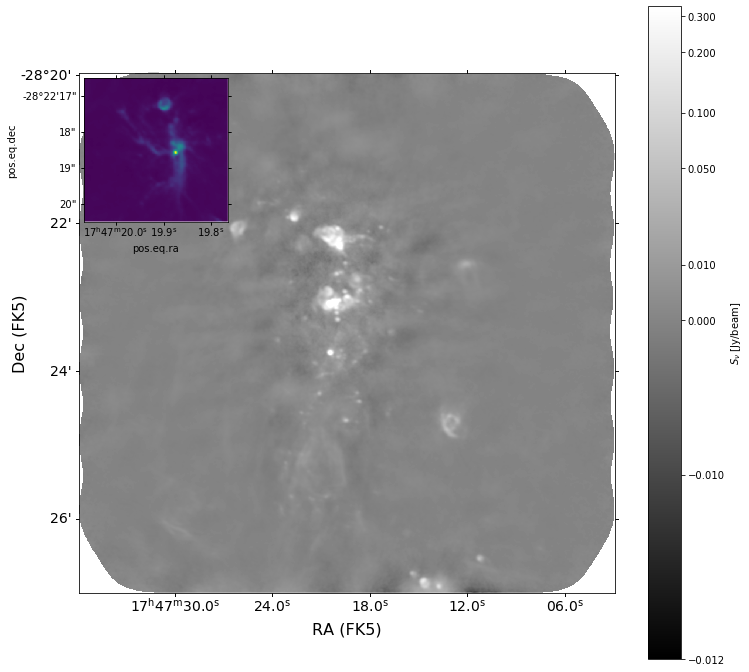

In [38]:
fig = pl.figure(figsize=(12,12))
ax = basefigure()

axins2 = inset_axes(ax,
                   loc=2, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww2))
xl,xr = 2650,2850
yl,yr = 2650,2850
axins2.imshow(im2[yl:yr,xl:xr], extent=[xl,xr,yl,yr],
             )
# the normal connector doesn't work here

There was actually a lot of work to do to get the insets to work... but I've done it for you:

In [39]:
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector
from matplotlib.transforms import Bbox

def mark_inset_otherdata(axins, parent_ax, bl, tr, loc1, loc2, edgecolor='b'):
        blt = bl.transform_to(parent_ax.wcs.wcs.radesys.lower())
        trt = tr.transform_to(parent_ax.wcs.wcs.radesys.lower())
        (rx1,ry1),(rx2,ry2) = (parent_ax.wcs.wcs_world2pix([[blt.ra.deg,
                                                             blt.dec.deg]],0)[0],
                               parent_ax.wcs.wcs_world2pix([[trt.ra.deg,
                                                             trt.dec.deg]],0)[0]
                              )
        bbox = Bbox(np.array([(rx1,ry1),(rx2,ry2)]))
        rect = TransformedBbox(bbox, parent_ax.transData)

        markinkwargs = dict(fc='none', ec=edgecolor)

        pp = BboxPatch(rect, fill=False, **markinkwargs)
        parent_ax.add_patch(pp)

        p1 = BboxConnector(axins.bbox, rect, loc1=loc1, **markinkwargs)
        axins.add_patch(p1)
        p1.set_clip_on(False)
        p2 = BboxConnector(axins.bbox, rect, loc1=loc2, **markinkwargs)
        axins.add_patch(p2)
        p2.set_clip_on(False)

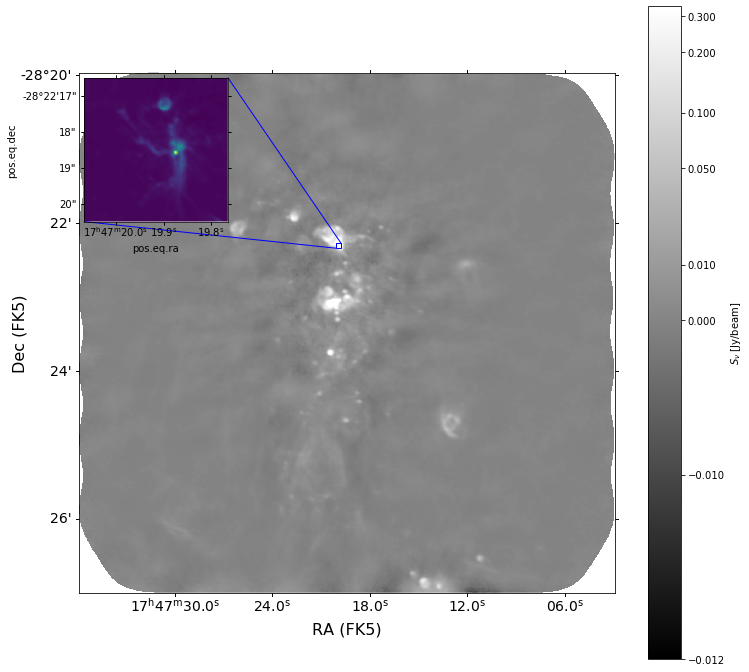

In [40]:
fig = pl.figure(figsize=(12,12))
ax = basefigure()

axins2 = inset_axes(ax,
                   loc=2, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww2))
xl,xr = 2650,2850
yl,yr = 2650,2850
bl = coordinates.SkyCoord(*ww2.wcs_pix2world(xl, yl, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww2.wcs_pix2world(xr, yr, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
axins2.imshow(im2[yl:yr,xl:xr], extent=[xl,xr,yl,yr],
             )
mark_inset_otherdata(axins2, ax, bl, tr, 1, 3,)

I don't want to see those ticks.

In [41]:
def hide_ticks(ax):
    ra = ax.coords['ra']
    dec = ax.coords['dec']
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ra.set_ticks_visible(False)
    dec.set_ticks_visible(False)
    ra.set_axislabel('')
    dec.set_axislabel('')
    ra.ticklabels.set_visible(False)
    dec.ticklabels.set_visible(False)

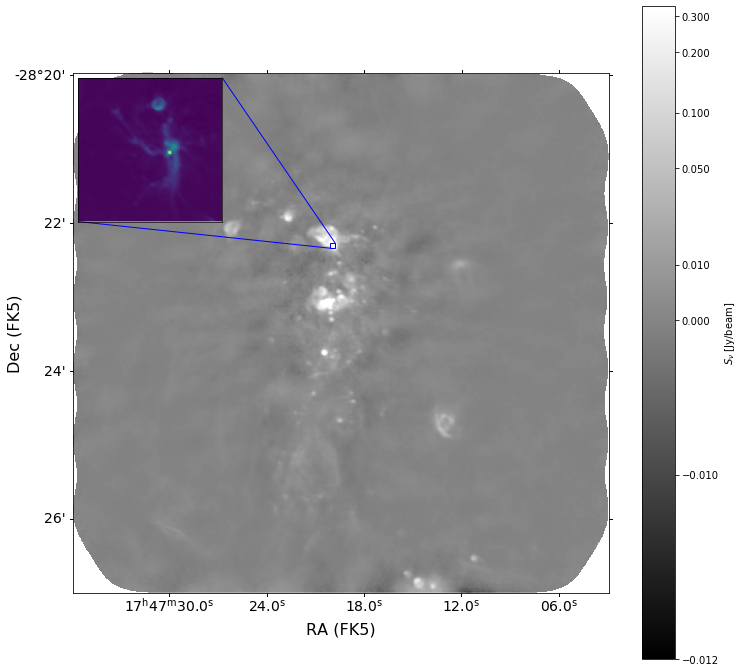

In [42]:
fig = pl.figure(figsize=(12,12))
ax = basefigure()

axins2 = inset_axes(ax,
                   loc=2, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww2))
xl,xr = 2650,2850
yl,yr = 2650,2850
bl = coordinates.SkyCoord(*ww2.wcs_pix2world(xl, yl, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww2.wcs_pix2world(xr, yr, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
axins2.imshow(im2[yl:yr,xl:xr], extent=[xl,xr,yl,yr],
             )
mark_inset_otherdata(axins2, ax, bl, tr, 1, 3,)
hide_ticks(axins2)

Let's add another data set.

In [43]:
fh3 = fits.open('/orange/adamginsburg/sgrb2/2017.1.00114.S/imaging_results/Sgr_B2_DS_B6_uid___A001_X1290_X46_continuum_merged_12M_robust-2_selfcal4_finaliter.image.tt0.pbcor.fits')
im3 = fh3[0].data.squeeze() # get rid of non-celestial axes
ww3 = WCS(fh3[0].header).celestial
im3.shape,ww3

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


((3750, 2304),
 WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---SIN'  'DEC--SIN'  
 CRVAL : 266.84006239  -28.416220037  
 CRPIX : 1153.0  1876.0  
 PC1_1 PC1_2  : 1.0  0.0  
 PC2_1 PC2_2  : 0.0  1.0  
 CDELT : -1.388888888889e-05  1.388888888889e-05  
 NAXIS : 2304  3750)

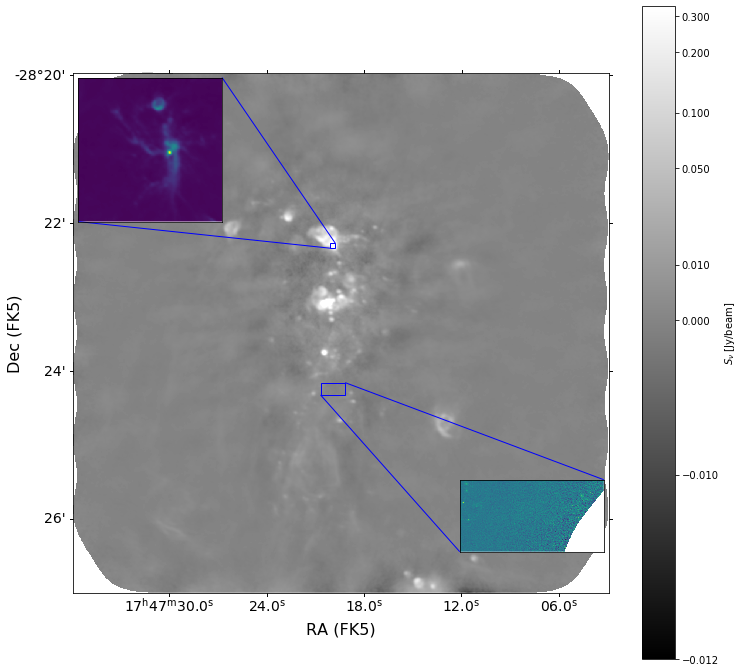

In [44]:
fig = pl.figure(figsize=(12,12))
ax = basefigure()

axins = inset_axes(ax,
                   loc=4, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww3))
xl,xr = 1400,1800
yl,yr = 2650,2850
bl = coordinates.SkyCoord(*ww3.wcs_pix2world(xl, yl, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww3.wcs_pix2world(xr, yr, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
axins.imshow(im3[yl:yr,xl:xr], extent=[xl,xr,yl,yr],
             )
mark_inset_otherdata(axins, ax, bl, tr, 1, 3,)
hide_ticks(axins)

axins2 = inset_axes(ax,
                   loc=2, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww2))
xl,xr = 2650,2850
yl,yr = 2650,2850
bl = coordinates.SkyCoord(*ww2.wcs_pix2world(xl, yl, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww2.wcs_pix2world(xr, yr, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
axins2.imshow(im2[yl:yr,xl:xr], extent=[xl,xr,yl,yr],
             )
mark_inset_otherdata(axins2, ax, bl, tr, 1, 3,)
hide_ticks(axins2)

Oops, I missed.  But now I have some sense of where to point...

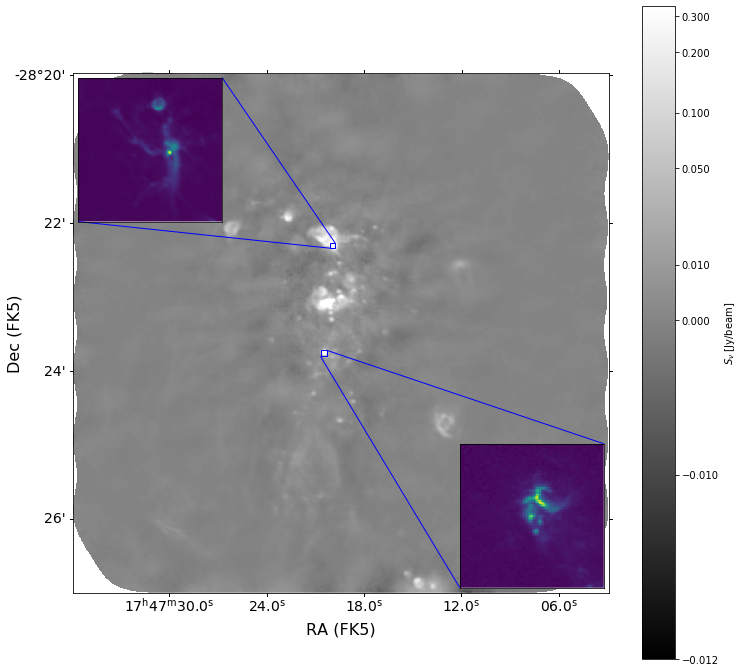

In [45]:
fig = pl.figure(figsize=(12,12))
ax = basefigure()

axins = inset_axes(ax,
                   loc=4, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww3))
xl,xr = 1400,1500
yl,yr = 3275,3375
bl = coordinates.SkyCoord(*ww3.wcs_pix2world(xl, yl, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww3.wcs_pix2world(xr, yr, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
axins.imshow(im3[yl:yr,xl:xr], extent=[xl,xr,yl,yr],
             )
mark_inset_otherdata(axins, ax, bl, tr, 1, 3,)
hide_ticks(axins)

axins2 = inset_axes(ax,
                   loc=2, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww2))
xl,xr = 2650,2850
yl,yr = 2650,2850
bl = coordinates.SkyCoord(*ww2.wcs_pix2world(xl, yl, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww2.wcs_pix2world(xr, yr, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
axins2.imshow(im2[yl:yr,xl:xr], extent=[xl,xr,yl,yr],
             )
mark_inset_otherdata(axins2, ax, bl, tr, 1, 3,)
hide_ticks(axins2)

I want to add in a third now

In [46]:
fh4 = fits.open('/orange/adamginsburg/sgrb2/NB/NB.sgr_b2.M.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits')
im4 = fh4[0].data.squeeze() # get rid of non-celestial axes
ww4 = WCS(fh4[0].header).celestial
im4.shape,ww4

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


((5488, 5488),
 WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---SIN'  'DEC--SIN'  
 CRVAL : 266.8340597456  -28.3846633396  
 CRPIX : 2745.0  2745.0  
 PC1_1 PC1_2  : 1.0  0.0  
 PC2_1 PC2_2  : 0.0  1.0  
 CDELT : -5.555555555556e-06  5.555555555556e-06  
 NAXIS : 5488  5488)

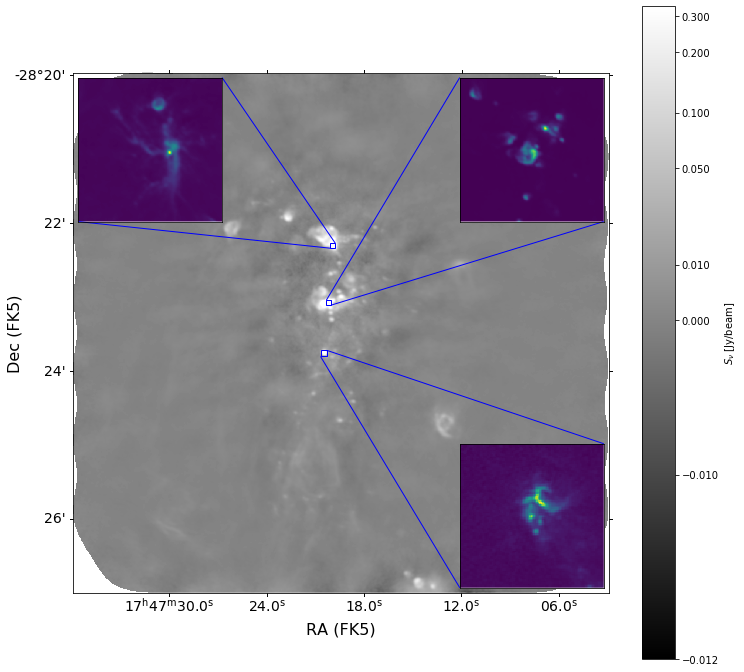

In [47]:
fig = pl.figure(figsize=(12,12))
ax = basefigure()

axins = inset_axes(ax,
                   loc=4, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww3))
xl,xr = 1400,1500
yl,yr = 3275,3375
bl = coordinates.SkyCoord(*ww3.wcs_pix2world(xl, yl, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww3.wcs_pix2world(xr, yr, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
axins.imshow(im3[yl:yr,xl:xr], extent=[xl,xr,yl,yr],
             )
mark_inset_otherdata(axins, ax, bl, tr, 1, 3,)
hide_ticks(axins)

axins2 = inset_axes(ax,
                   loc=2, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww2))
xl,xr = 2650,2850
yl,yr = 2650,2850
bl = coordinates.SkyCoord(*ww2.wcs_pix2world(xl, yl, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww2.wcs_pix2world(xr, yr, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
axins2.imshow(im2[yl:yr,xl:xr], extent=[xl,xr,yl,yr],
             )
mark_inset_otherdata(axins2, ax, bl, tr, 1, 3,)
hide_ticks(axins2)


axins3 = inset_axes(ax,
                   loc=1, width=2, height=2,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww4))
xl,xr = 2650,2850
yl,yr = 2650,2850
bl = coordinates.SkyCoord(*ww4.wcs_pix2world(xl, yl, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww4.wcs_pix2world(xr, yr, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
axins3.imshow(im4[yl:yr,xl:xr], extent=[xl,xr,yl,yr],
             )
mark_inset_otherdata(axins3, ax, bl, tr, 2, 4,)
hide_ticks(axins3)

The above image is pretty good, but there is a ton more that could be done to clean it up.

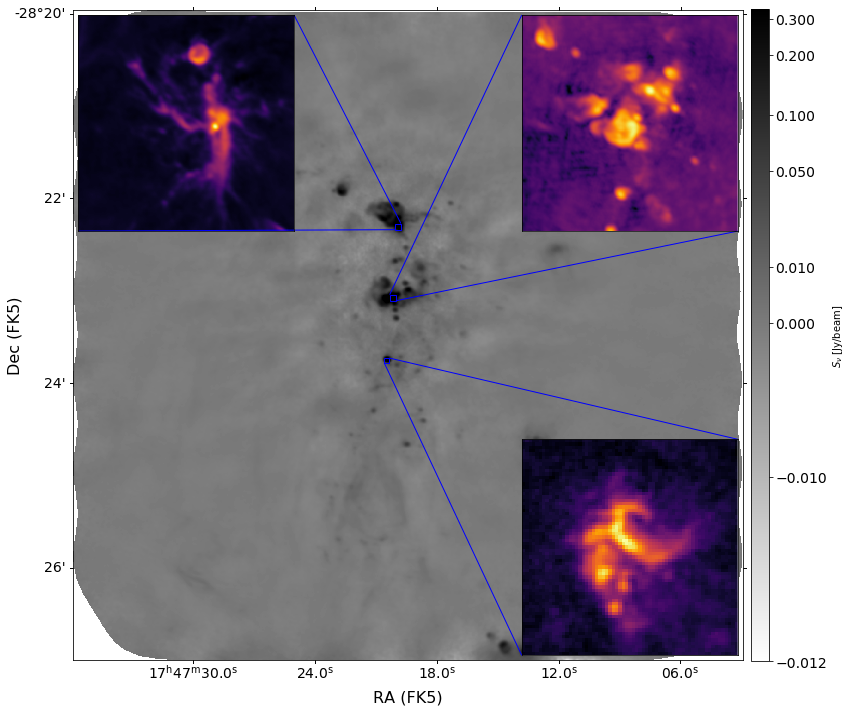

In [48]:
tick_fontsize = 14
fontsize = 16

fig = pl.figure(figsize=(12,12))
ax = fig.add_subplot(projection=ww)
im = ax.imshow(fh[0].data, cmap='gray_r',
               norm=visualization.simple_norm(fh[0].data, stretch='log', max_percent=99.95))

divider = make_axes_locatable(ax)
cax = fig.add_axes([ax.get_position().x1+0.01,
                     ax.get_position().y0,
                     0.02,
                     ax.get_position().height])

cb = pl.colorbar(mappable=im, cax=cax)
cb.set_label(f"$S_\\nu$ [{fh[0].header['BUNIT']}]")
cb.set_ticks([np.nanmin(fh[0].data), -0.01, 0.00, 0.01, 0.05, 0.10, 0.20, 0.30])
cb.ax.tick_params(labelsize=tick_fontsize)
ax.axis([167,1617,210,1618])
radesys = ww.wcs.radesys
_ = ax.set_xlabel(f"Right Ascension {radesys}")
_ = ax.set_ylabel(f"Declination {radesys}")


ra = ax.coords['ra']
ra.set_major_formatter('hh:mm:ss.s')
dec = ax.coords['dec']
ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
ra.ticklabels.set_fontsize(tick_fontsize)
ra.set_ticklabel(exclude_overlapping=True)
dec.ticklabels.set_fontsize(tick_fontsize)
dec.set_ticklabel(exclude_overlapping=True)

axins = inset_axes(ax,
                   loc=4, width=3, height=3,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww3))
xl,xr = 1425,1490
yl,yr = 3300,3365
bl = coordinates.SkyCoord(*ww3.wcs_pix2world(xl, yl, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww3.wcs_pix2world(xr, yr, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
axins.imshow(im3[yl:yr,xl:xr], extent=[xl,xr,yl,yr], cmap='inferno',
             norm=simple_norm(im3[yl:yr,xl:xr], stretch='asinh')
             )
mark_inset_otherdata(axins, ax, bl, tr, 1, 3,)
hide_ticks(axins)

axins2 = inset_axes(ax,
                   loc=2, width=3, height=3,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww2))
xl,xr = 2650,2850
yl,yr = 2650,2850
bl = coordinates.SkyCoord(*ww2.wcs_pix2world(xl, yl, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww2.wcs_pix2world(xr, yr, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
axins2.imshow(im2[yl:yr,xl:xr], extent=[xl,xr,yl,yr], cmap='inferno',
              norm=simple_norm(im2[yl:yr,xl:xr], stretch='asinh')
             )
mark_inset_otherdata(axins2, ax, bl, tr, 1, 3,)
hide_ticks(axins2)


axins3 = inset_axes(ax,
                   loc=1, width=3, height=3,
                   axes_class=visualization.wcsaxes.core.WCSAxes,
                   axes_kwargs=dict(wcs=ww4))
xl,xr = 2650,2850
yl,yr = 2650,2850
bl = coordinates.SkyCoord(*ww4.wcs_pix2world(xl, yl, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
tr = coordinates.SkyCoord(*ww4.wcs_pix2world(xr, yr, 0), frame=ww2.wcs.radesys.lower(), unit=(u.deg,u.deg))
axins3.imshow(im4[yl:yr,xl:xr], extent=[xl,xr,yl,yr], cmap='inferno',
              norm=simple_norm(im4[yl:yr,xl:xr], stretch='log')              
             )
mark_inset_otherdata(axins3, ax, bl, tr, 2, 4,)
hide_ticks(axins3)